# Import the required libraries

In [1]:
def plot1_cnf_matrix(conf_matrix):
    """Input:
    Conf_matrix -- Confustion matrix (test labels, predicted labels) of size (10,10)
    Confusion matrix  is such that the (i,j) element is equal to the number of observations
    known to be in group 'i' and predicted to be in group 'j' .
    """
    df_cm = pd.DataFrame(conf_matrix, range(np.shape(conf_matrix)[0]), range(np.shape(conf_matrix)[1]))
    df_cm.head()
    plt.figure(figsize=(20,20))    #to specify the figure size
    plt.title("CONFUSION MATRIX : Y-axis : True class X-axis : Predicted Class")
    sn.set(font_scale=1.4)         # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size":16},fmt='d') # font size
    plt.show()

<ipython-input-914-3e67fa4087aa>:5: RuntimeWarning: divide by zero encountered in double_scalars
  b[i]=stat.expon.pdf(2,scale=1/a[i])


0.5005005005005005


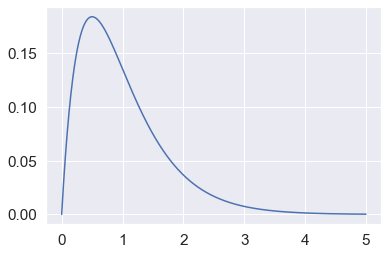

In [914]:
a=[0,0.2,0.4,0.8,1,2,3,4,5]
a=np.linspace(0,5,1000)
b=np.zeros((len(a),1))
for i in range(len(a)):
    b[i]=stat.expon.pdf(2,scale=1/a[i])
    #print(b[i])
plt.plot(a,b)
c=np.argmax(b)
print(a[c])

In [897]:
from mnist import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Problem 1: a) Gaussian Distribution

 Estimated mean for $i^{th}$ class is a vector with 784 mean feature values(pixel values) with $j^{th}$ pixel value equal to: 
\begin{equation}
\mu_{ij}=\sum_{l=1}^m\frac{x_{jl}}{m},
\end{equation}
where, m is the number of images of $i^{th}$ particular class and $\newline$
$x_{jl}$ is the $j^{th}$ pixel value of $l^{th}$ image. 
$\newline $
The vaiance is a matrix and for  $i^{th}$ class it is ,
\begin{equation}
\Sigma_i=\sum_{l=1}^m\frac{z_l}{m},
\end{equation}
where, $z_l=\frac{(x_l-\mu_i)*(x_l-\mu_i)^T}{n}$
$\newline$
Here $x_l$ represents $l^{th}$ image of $i^{th}$ class and $\mu_i$ represents the mean of $i^{th}$ class images.


## MLE Estimation for Training Data with Class Conditional densities modeled as Multivariate Gaussian Distribution 

In [860]:
def mle_estimation_gaussian(train_images,train_labels):
    
    classes=[[] for i in range(np.max(train_labels)+1)]  #creates a list of 10 empty lists with each list referring to a class in our case (10 classes)
    for i in range(len(train_labels)):
          classes[train_labels[i]].append(train_images[i]) # the images with label k is added to the class k. 


    mu= np.array([np.mean(classes[i],axis=0) for i in range(np.max(train_labels)+1)])  #generate the MLE estimated mean vectors for each class

    temp_var=[np.array(classes[i][:][:]) for i in range(np.max(train_labels)+1)]   #each item in the list contains all the  feature vectors of a class 
    temp_var=[temp_var[i].T for i in range(np.max(train_labels)+1)]                  #take the transpose of each matrix present in the list
    #print(np.shape(mu))          #to know the shape of mean


    covariance=[((np.cov(temp_var[i]))/(np.shape(temp_var[i])[1]))+ 0.35*np.identity(len(temp_var[i])) for i in range(np.max(train_labels)+1)]     #find the MLE estimated covarinace matrix for each class
#     for i in range(10):
#         print(np.linalg.det(covariance[i]))
    #print(np.shape(covariance[1]))         #to know the shape of varainace


    #Below 3 lines is to calculate the prior probabilites of each class.
    prior_prob=np.zeros((np.max(train_labels)+1,1))
    for i in range(np.max(train_labels)+1):
        prior_prob[i]=len(classes[i])/(np.shape(train_images)[0])    


# print("prior probabilities")
# print(prior_prob)            #to print the prior probabilities

#to plot the images with pixel values of a class (0-9) equal to the mean values of the corresponding classes
    plt.suptitle("Images constructed using mean values of pixels for each class")
    for i in range(np.max(train_labels)+1):
        plt.subplot(2,5,i+1)
        train_imag1=mu[i][:]
        train_imag1=np.array(train_imag1)
        train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
        plt.imshow(train_imag1)
        plt.axis('off')
        plt.title("Class "+str(i))
        

#     plt.show()
    return mu,covariance,prior_prob 

## Bayes Classfier for Test Data with Class Conditional densities modeled as Multivariate Gaussian Distribution 

In [861]:
def bayes_clasfr_gaussian(test_images,test_labels,mu,covariance,prior_prob):
  
  mis_clf=0   
  
  predicted_label=np.zeros((len(test_images)))    #to store the predicted label for each image
  #print(np.shape(predicted_label))

  for i in range(len(test_labels)):
    temp_image=np.array(test_images[i][:])   #load the feature vector of particular image that needs to be classified
    pst_prob=np.zeros((np.max(train_labels)+1))           #to store posterior probabilites given the feature vector
    
    for j in range(np.max(test_labels)+1):
        covariance_temp=covariance[j][:][:]   # load the co-variance matrix of jth class
        mu_temp=np.array(mu[j,:])             #load the mean vector of jth class
        x=(temp_image-mu_temp).T@np.linalg.inv(covariance_temp)@(temp_image-mu_temp)
        #print(np.log(np.linalg.det(covariance_temp)))
        pst_prob[j]=-0.5*len(covariance_temp)*np.log(2*np.pi)-0.5*np.log(np.linalg.det(covariance_temp))-0.5*x + np.log(prior_prob[j])   #find the PDF of the feature vector that follows the given distribution 
      
    predicted_label[i]=np.argmax(pst_prob)                                #find the index at which the posterior probability is maximum
      
    if predicted_label[i]!=test_labels[i]:
        mis_clf+=1
        #print(i,mis_clf,predicted_label[i],test_labels[i])                 #to print the predicted class and ture class of a mis-classified image

  #print(np.shape(predicted_label))
  test_labels=np.array(test_labels)
  #to create the confusion matrix
  conf_matrix=confusion_matrix(test_labels,predicted_label)       #to create the confusion matrix
  
  return conf_matrix,mis_clf

# The below cell is to plot Confusion Matrix

In [862]:
def plot_cnf_matrix(conf_matrix):
    df_cm = pd.DataFrame(conf_matrix, range(np.shape(conf_matrix)[0]), range(np.shape(conf_matrix)[1]))
    plt.figure(figsize=(20,20))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size":16},fmt='d') # font size
    plt.show()


# Training the Model and Testing the Model: : 

Total no. of images uses for training : 60000
No. of pixel values for each image : 784
No. of classes is : 10
Classifier : Bayes Classifier and Class Conditional densities for training Data : Mulitvariate Gaussian Distribution
Prior Probability of class 0 is 0.099
Prior Probability of class 1 is 0.112
Prior Probability of class 2 is 0.099
Prior Probability of class 3 is 0.102
Prior Probability of class 4 is 0.097
Prior Probability of class 5 is 0.09
Prior Probability of class 6 is 0.099
Prior Probability of class 7 is 0.104
Prior Probability of class 8 is 0.098
Prior Probability of class 9 is 0.099


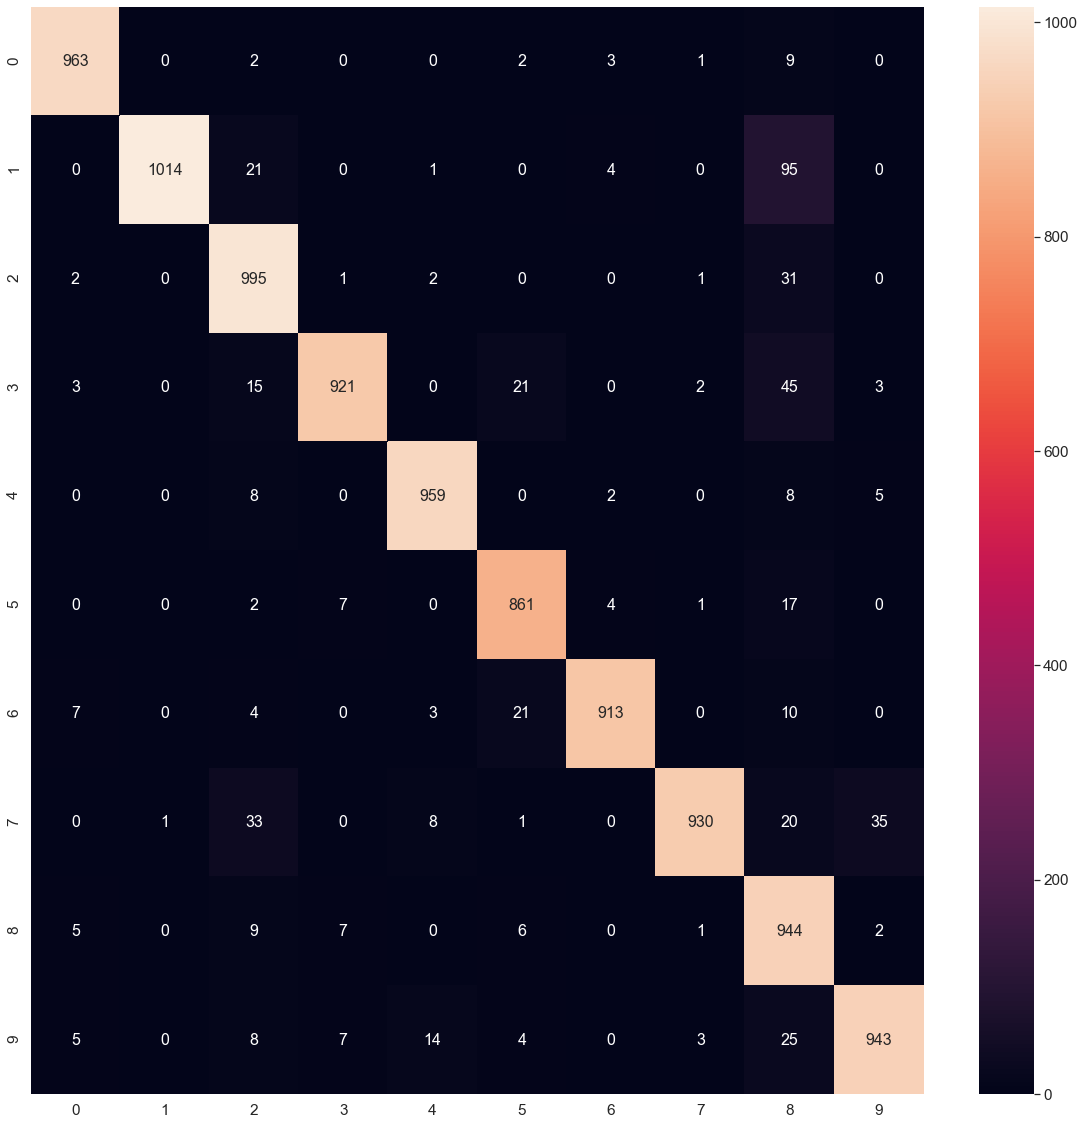

The % of misclassification is 5.57% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution


In [869]:
mndata=MNIST(r"Dataset_spr_2")  #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels 

train_images, train_labels=mndata.load_training()      #loads training images and their labels
#print(np.shape(train_images[1]))         #(60,0000,784) there are 60,000 images with each of size 28x28  
#print(np.shape(train_labels))         #(60,000,) labels
test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
test_images=np.array(test_images)
#print(np.shape(test_images))

mu,covariance,prior_prob = mle_estimation_gaussian(train_images,train_labels)

print(f"Total no. of images uses for training : {str(len(train_images))}")
print(f"No. of pixel values for each image : {str(np.shape(train_images)[1])}")
print(f"No. of classes is : {str(np.max(train_labels)+1)}")
print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data : Mulitvariate Gaussian Distribution")
for i in range(np.max(train_labels)+1):
    print("Prior Probability of class " + str(i) + " is "  + str(round(prior_prob[i,0],3)))

conf_matrix,mis_clf = bayes_clasfr_gaussian(test_images,test_labels,mu,covariance,prior_prob)

plot_cnf_matrix(conf_matrix)

perc_misclf= mis_clf/len(test_labels)

print(f"The % of misclassification is {str(perc_misclf*100)}% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution")


In [894]:
def bayes_clasfr_gaussian_combine(test_images,test_labels,mu,covariance,prior_prob,combined_class):
    mis_clf=0

    predicted_label=np.zeros((len(test_images)))    #to store the predicted label for each image
    #print(np.shape(predicted_label) 
    mod_test_label=range(np.max(test_labels)+1)  #hard_coded the labels as the generalised code didnot work
    cmb_class=''
    for i in range(len(combined_class)):
        cmb_class+=str(combined_class[i])
    
    cmb_class=int(cmb_class)
    
    mod_test_label=[i if i!=combined_class[i%2] else cmb_class for i in mod_test_label]    
    
    #print(np.shape(mod_test_label))
    
#     mod_test_label=np.append(mod_test_label,cmb_class)
    #print(np.shape(mod_test_label))
    
    for i in range(len(test_labels)): 
        if test_labels[i] in combined_class:
            test_labels[i]=cmb_class
    
    for i in range(len(test_labels)):
        temp_image=np.array(test_images[i][:])   #load the feature vector of particular image that needs to be classified
        pst_prob=np.zeros((np.max(train_labels)+1-len(combined_class)+1))           #to store posterior probabilites given the feature vector
        
        for j in range(len(mu)):
            covariance_temp=covariance[j][:][:]   # load the co-variance matrix of jth class
            #print(np.shape(covariance))
            mu_temp=np.array(mu[j][:])             #load the mean vector of jth class
            x=(temp_image-mu_temp).T@np.linalg.inv(covariance_temp)@(temp_image-mu_temp)
            #print(np.log(np.linalg.det(covariance_temp)))
            pst_prob[j]=-0.5*len(covariance_temp)*np.log(2*np.pi)-0.5*np.log(np.linalg.det(covariance_temp))-0.5*x + np.log(prior_prob[j])   #find the PDF of the feature vector that follows the given distribution 

        predicted_label[i]=mod_test_label[np.argmax(pst_prob)]                                #find the index at which the posterior probability is maximum
      
        if predicted_label[i]!=test_labels[i]:
            mis_clf+=1
            #print(i,mis_clf,predicted_label[i],test_labels[i])                 #to print the predicted class and ture class of a mis-classified image

    #print(np.shape(predicted_label))
    test_labels=np.array(test_labels)
    #to create the confusion matrix
    conf_matrix=confusion_matrix(test_labels,predicted_label)       #to create the confusion matrix
  
    return conf_matrix,mis_clf,mod_test_label

In [537]:
def plot_cnf_matrix_combine(conf_matrix,mod_test_label):
    df_cm = pd.DataFrame(conf_matrix, mod_test_label, mod_test_label)
    plt.figure(figsize=(20,20))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size":16},fmt='d') # font size
    plt.show()

## As misclassification of 1 and 3 (trueclass) as 8 (predicted class) is more. 

We combine the class 1, class 3 and class 8. The correspoding mean and varinaces of this combined class is $\frac{\mu_1+\mu_3+\mu_8}{3}$ and variance is $\frac{\Sigma_1+\Sigma_3+\Sigma_8}{3}$ 

In [888]:
def choose_dataset(mndata,combined_class):
    train_images, train_labels=mndata.load_training()      #loads training images and their labels
    #print(np.shape(train_images[1]))         #(60,0000,784) there are 60,000 images with each of size 28x28  
    #print(np.shape(train_labels))         #(60,000,) labels
    test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
    test_images=np.array(test_images)
    #print(np.shape(test_images))

    mu,covariance,prior_prob = mle_estimation_gaussian(train_images,train_labels)
    
    #to remove the mean and variances of classed to be combined.
    mask=np.ones(len(mu),dtype='bool')
    mask[combined_class]=False
    mod_mu=mu[mask]
    covar=np.array(covariance)
    mod_covariance=covar[mask]
    mod_prior_prob=prior_prob[mask]

    #to find the mean and variance of combined class
    mask=np.zeros(len(mu),dtype='bool')
    mask[combined_class]=True
    mu138=mu[mask]
    mu138=np.mean(mu138,axis=0)
    mu138=np.reshape(mu138,(1,784))

    mod_mu=np.append(mod_mu,mu138,axis=0)   # append the new mean of the combined class

    cov138=covar[mask]
    cov138=np.sum(cov138,axis=0)/len(combined_class)
    cov138=np.reshape(cov138,(1,784,784))

    mod_covariance=np.append(mod_covariance,cov138,axis=0)    #append the new varainace of the combined class

    p138=prior_prob[mask]
    p138=np.mean(p138)
    mod_prior_prob=np.append(mod_prior_prob,p138)    #append the new prior probability of the combined class

    # print(np.shape(mod_covariance))
    conf_matrix,mis_clf,mod_test_label=bayes_clasfr_gaussian_combine(test_images,test_labels,mod_mu,mod_covariance,mod_prior_prob,combined_class)

    plot_cnf_matrix_combine(conf_matrix,mod_test_label)

    perc_misclf= mis_clf/len(test_labels)

    print(f"The % of misclassification is {perc_misclf*100}% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution with classes 1,3,8 combined")



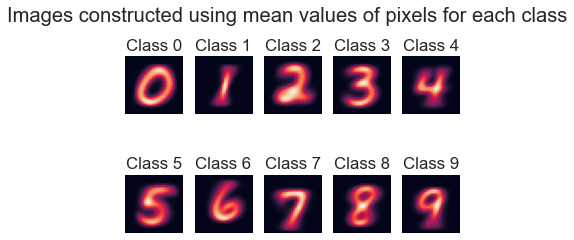

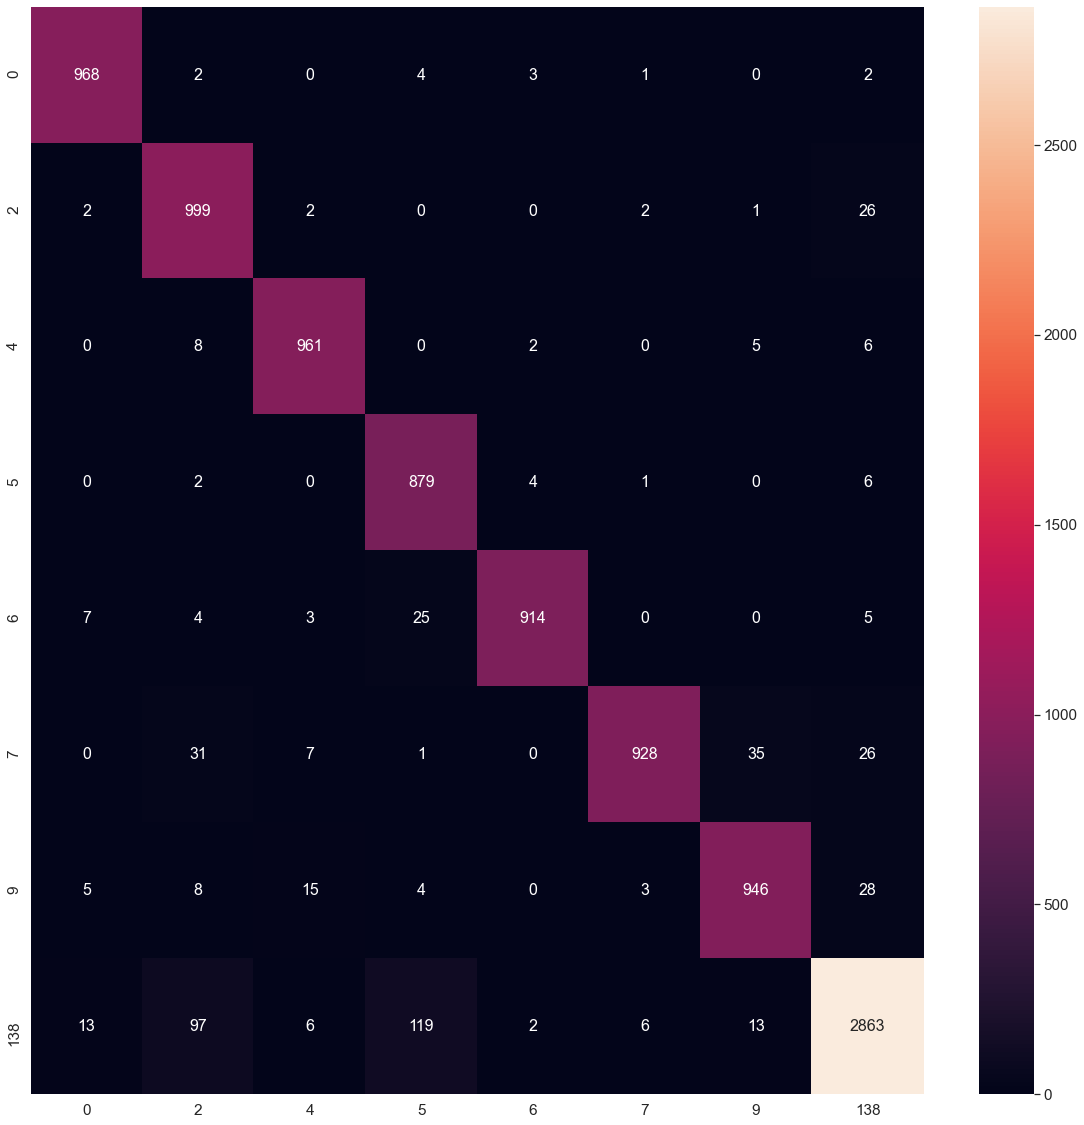

The % of misclassification is 5.42% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution with classes 1,3,8 combined


In [858]:
mndata=MNIST(r"Dataset_spr_2")  #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels 

combined_class=[1,3,8]

choose_dataset(mndata,combined_class)

## b) Exponential Distribution

Estimate of paramter $\lambda$ for $i^{th}$ class is a vector with 784 values with $j^{th}$ value equal to: 
\begin{equation}
\lambda_{ij}=\sum_{l=1}^m\frac{m}{x_{jl}},
\end{equation}
where, m is the number of images of $i^{th}$ particular class and $\newline$
$x_{jl}$ is the $j^{th}$ pixel value of $l^{th}$ image. 

## MLE Estimation for Training Data with Class Conditional densities modeled as Multivariate Exponential Distribution 

In [864]:
def mle_estimation_exp(train_images,train_labels,lamda_smoothing):
    
    classes=[[] for i in range(np.max(train_labels)+1)]  #creates a list of 10 empty lists with each list referring to a class in our case (10 classes)

    for i in range(len(train_labels)):
        classes[train_labels[i]].append(train_images[i]) # the images with label k is added to the class k. 



    lamda= np.array([1/((np.mean(classes[i],axis=0))) for i in range(np.max(train_labels)+1)])  #generate the MLE estimate of parameter lamda vector for each class

    lamda[lamda==np.inf]=lamda_smoothing  # np.unique(lamda)[-2]
    prior_prob=np.zeros((np.max(train_labels)+1,1))
    for i in range((np.max(train_labels)+1)):
        prior_prob[i]=len(classes[i])/(np.shape(train_images)[0])

#     print("prior probabilities")
#     print(prior_prob)
#     #to plot the images with pixel values of a class (0-9) equal to the mean values of the corresponding classes
    plt.suptitle("Images constructed using mean values of pixels for each class")
    for i in range(np.max(train_labels)+1):
        plt.subplot(2,5,i+1)
        train_imag1=lamda[i][:]
        train_imag1=np.array(1/(train_imag1))
        train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
        plt.imshow(train_imag1)
        plt.axis('off')
        plt.title("Class "+str(i))
        
    plt.show()
    
    return lamda,prior_prob 



## Bayes Classfier for Test Data with Class Conditional densities modeled as Multivariate Gaussian Distribution 

In [865]:
def bayes_clasfr(test_images,test_labels,lamda,prior_prob):
    mis_clf=0   
    predicted_label=[]
   
    for i in range(len(test_labels)):
        dmy=np.array(test_images[i][:])   #load the feature vector of particular image that needs to be classified
        #dmy=np.reshape(dmy,(1,784))
        pst_prob=np.zeros((np.max(test_labels)+1))           #to store posterior probabilites given the feature vector
        for j in range(np.max(test_labels)+1):

            lamda_temp=np.array(lamda[j,:])             #load the mean vector of jth class
            pst_prob[j]= np.sum(np.log(lamda_temp))+np.sum(-lamda_temp*dmy)+np.log(prior_prob[j])#np.sum(np.log(lamda_temp))-np.sum(lamda*dmy) + np.log(prior_prob[j])   #find the PDF of the feature vector that follows the given distribution 
        predicted_label.append(np.argmax(pst_prob))                                #find the index at which the posterior probability is maximum

        if predicted_label[i]!=test_labels[i]:
            mis_clf+=1
            #print(i,mis_clf,predicted_label[i],test_labels[i])                 #to print the predicted class and ture class of a mis-classified image

    #print(np.shape(predicted_label))
    test_labels=np.array(test_labels)
    predicted_label=np.array(predicted_label)

    #print(np.shape(predicted_label))

    conf_matrix=confusion_matrix(test_labels,predicted_label)       #to create the confusion matrix
    #print(mis_clf)
    return conf_matrix,mis_clf




## Training and Testing The Model:

Total no. of images uses for training : 60000
No. of pixel values for each image : 784
No. of classes is : 10


<ipython-input-864-c7f80f3173d1>:10: RuntimeWarning: divide by zero encountered in true_divide
  lamda= np.array([1/((np.mean(classes[i],axis=0))) for i in range(np.max(train_labels)+1)])  #generate the MLE estimate of parameter lamda vector for each class
<ipython-input-864-c7f80f3173d1>:24: RuntimeWarning: divide by zero encountered in true_divide
  train_imag1=np.array(1/(train_imag1))


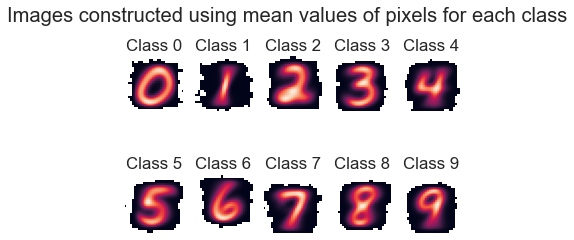

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.09871666666666666
Prior Probability of class 0 is 0.11236666666666667
Prior Probability of class 0 is 0.0993
Prior Probability of class 0 is 0.10218333333333333
Prior Probability of class 0 is 0.09736666666666667
Prior Probability of class 0 is 0.09035
Prior Probability of class 0 is 0.09863333333333334
Prior Probability of class 0 is 0.10441666666666667
Prior Probability of class 0 is 0.09751666666666667
Prior Probability of class 0 is 0.09915


<ipython-input-865-a702fd3e510d>:12: RuntimeWarning: divide by zero encountered in log
  pst_prob[j]= np.sum(np.log(lamda_temp))+np.sum(-lamda_temp*dmy)+np.log(prior_prob[j])#np.sum(np.log(lamda_temp))-np.sum(lamda*dmy) + np.log(prior_prob[j])   #find the PDF of the feature vector that follows the given distribution


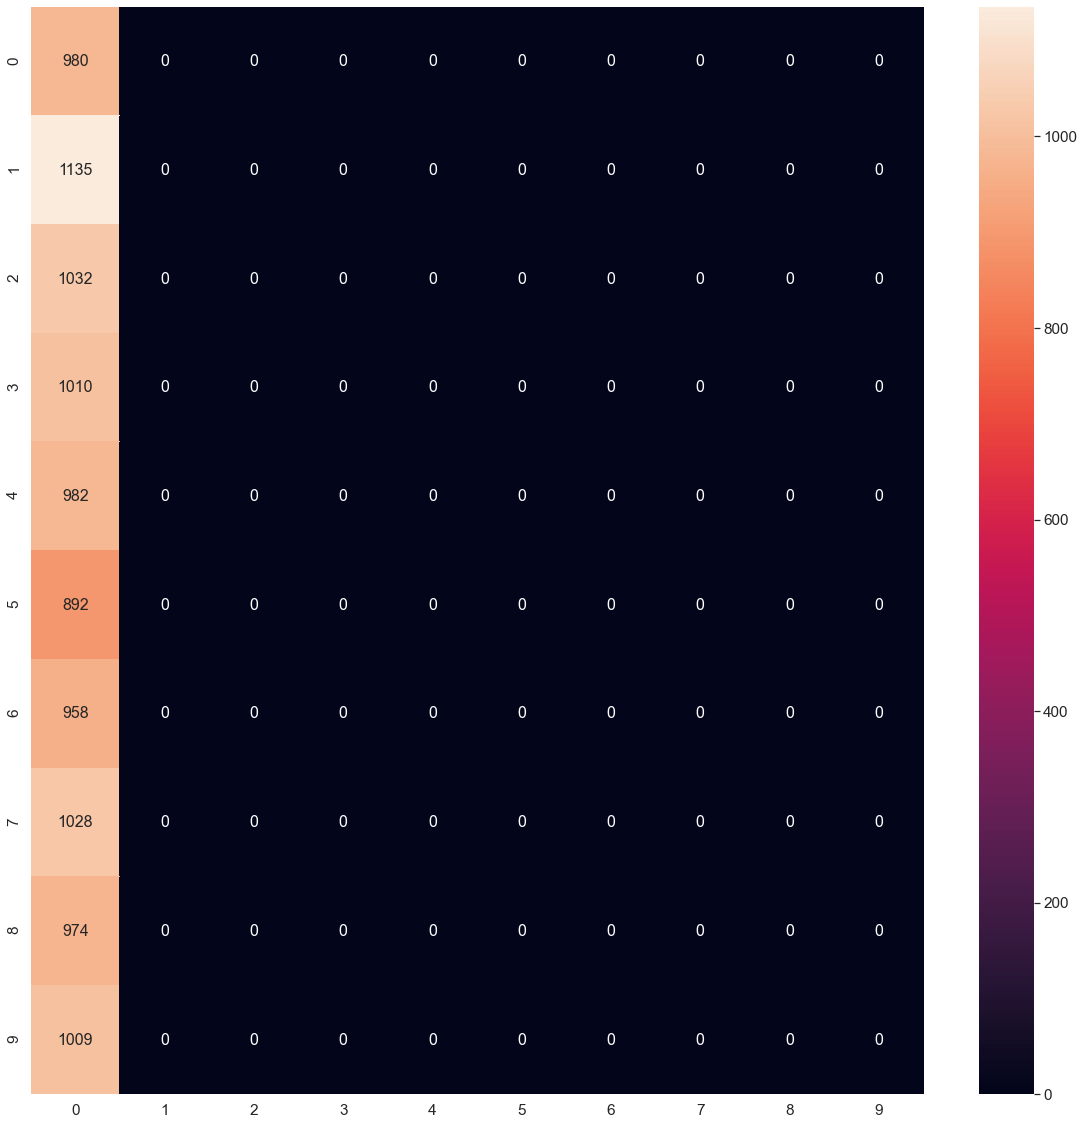

The % of misclassification is 90.2% when the noise added to the lambda is 0


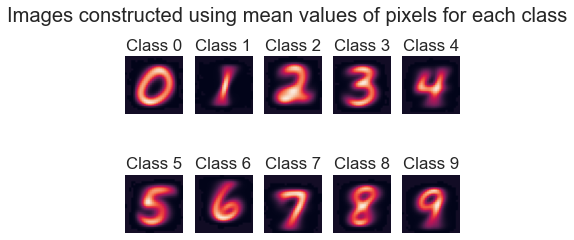

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 1 is 0.09871666666666666
Prior Probability of class 1 is 0.11236666666666667
Prior Probability of class 1 is 0.0993
Prior Probability of class 1 is 0.10218333333333333
Prior Probability of class 1 is 0.09736666666666667
Prior Probability of class 1 is 0.09035
Prior Probability of class 1 is 0.09863333333333334
Prior Probability of class 1 is 0.10441666666666667
Prior Probability of class 1 is 0.09751666666666667
Prior Probability of class 1 is 0.09915


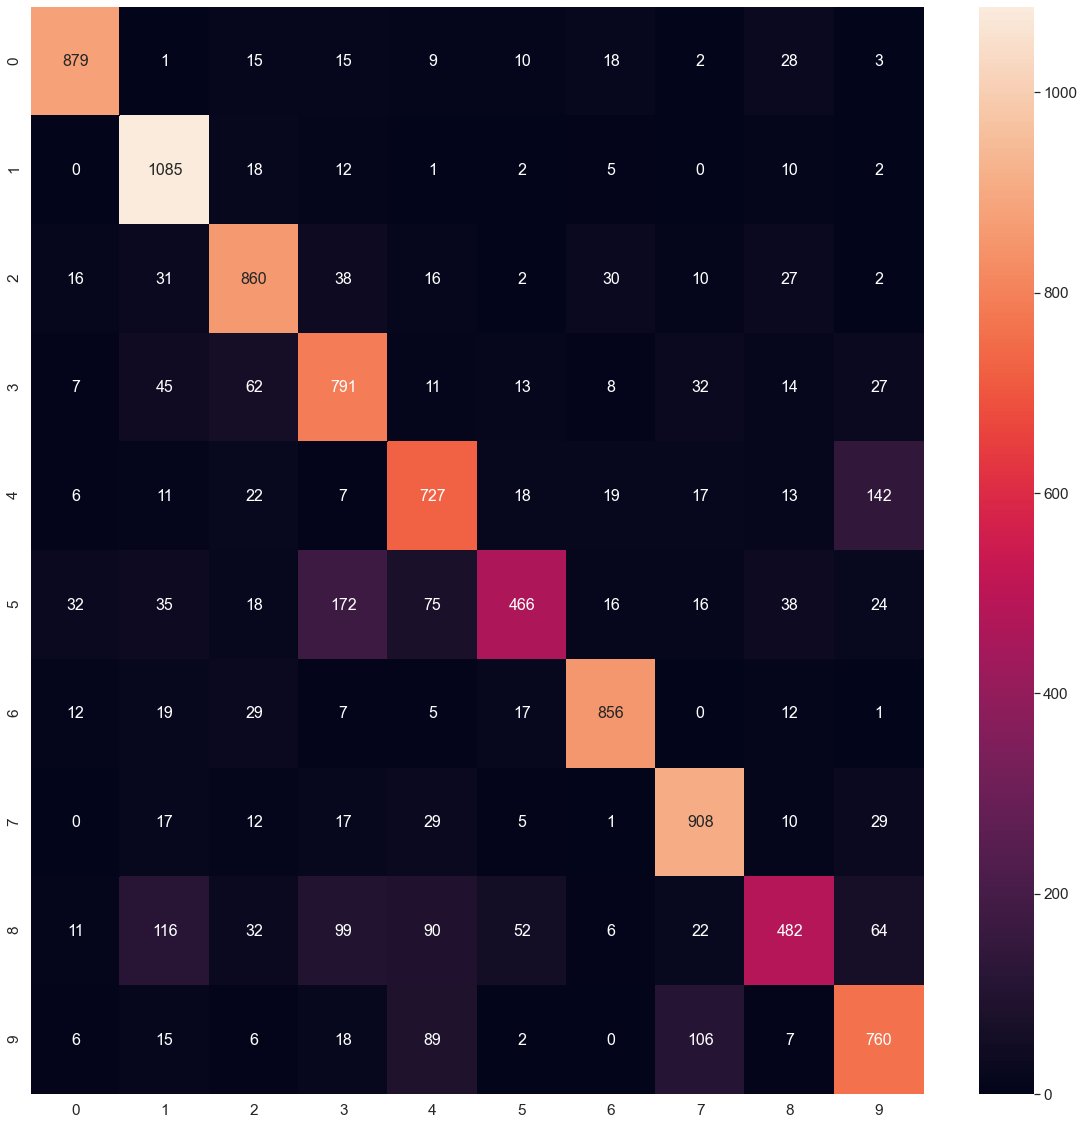

The % of misclassification is 21.86% when the noise added to the lambda is 0.1


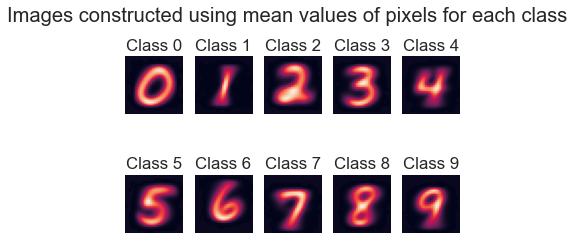

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 2 is 0.09871666666666666
Prior Probability of class 2 is 0.11236666666666667
Prior Probability of class 2 is 0.0993
Prior Probability of class 2 is 0.10218333333333333
Prior Probability of class 2 is 0.09736666666666667
Prior Probability of class 2 is 0.09035
Prior Probability of class 2 is 0.09863333333333334
Prior Probability of class 2 is 0.10441666666666667
Prior Probability of class 2 is 0.09751666666666667
Prior Probability of class 2 is 0.09915


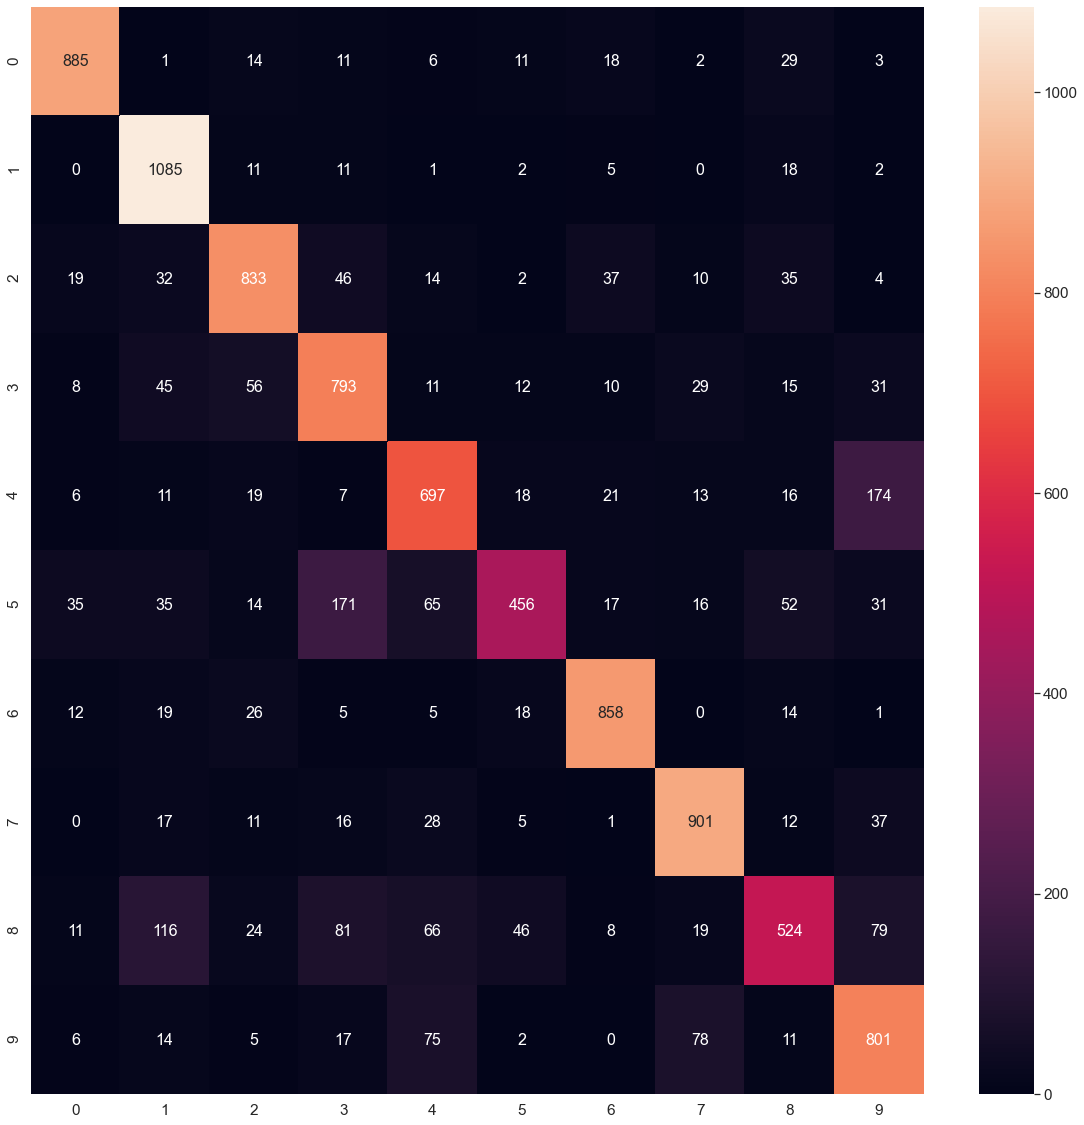

The % of misclassification is 21.67% when the noise added to the lambda is 0.18


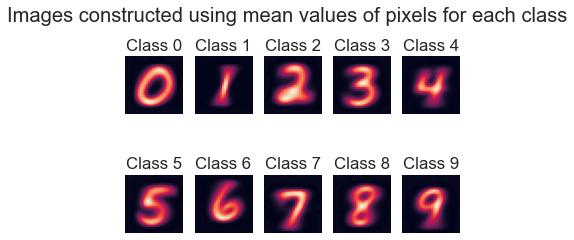

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 3 is 0.09871666666666666
Prior Probability of class 3 is 0.11236666666666667
Prior Probability of class 3 is 0.0993
Prior Probability of class 3 is 0.10218333333333333
Prior Probability of class 3 is 0.09736666666666667
Prior Probability of class 3 is 0.09035
Prior Probability of class 3 is 0.09863333333333334
Prior Probability of class 3 is 0.10441666666666667
Prior Probability of class 3 is 0.09751666666666667
Prior Probability of class 3 is 0.09915


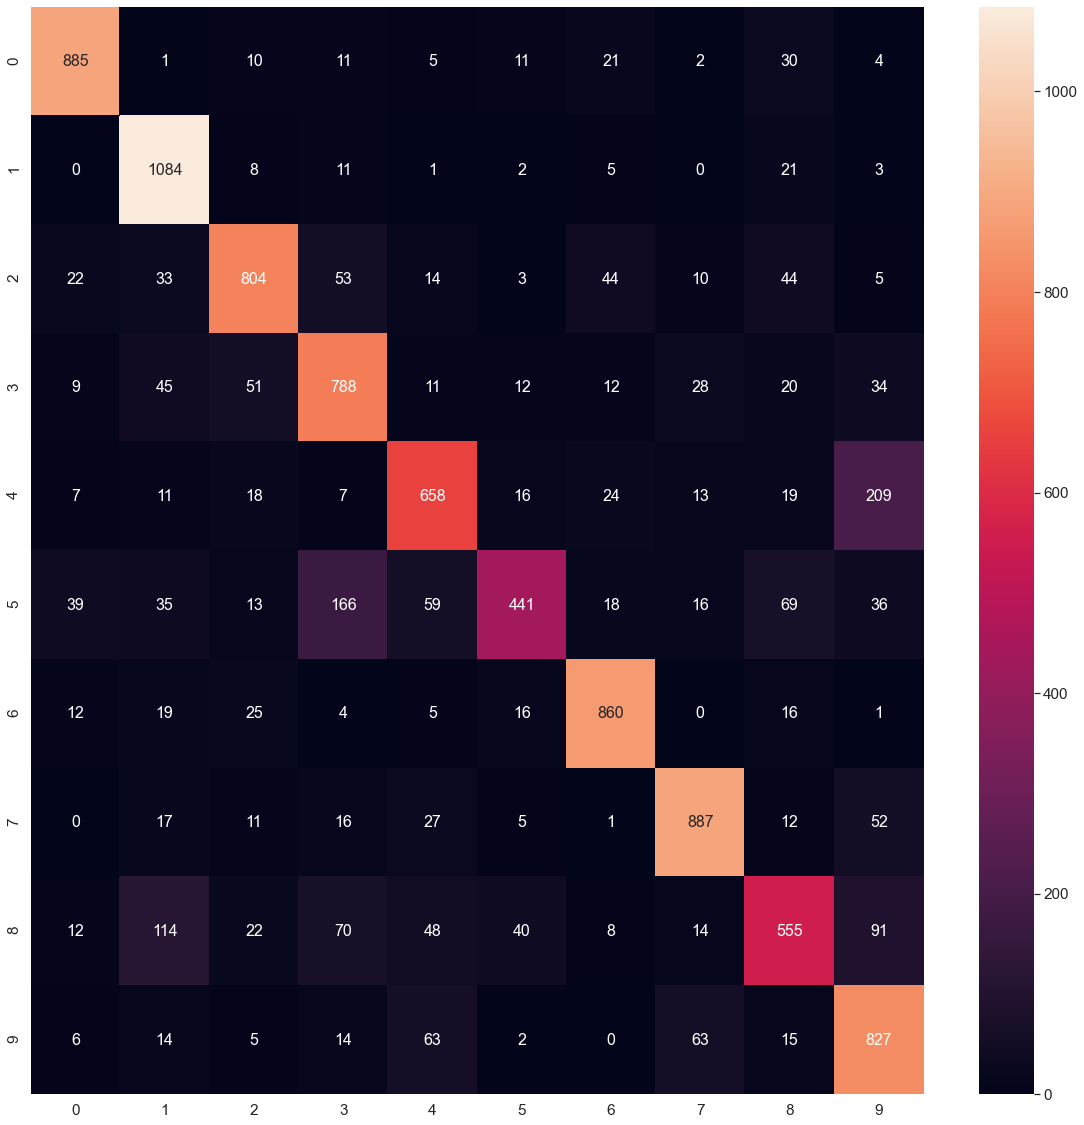

The % of misclassification is 22.11% when the noise added to the lambda is 0.3


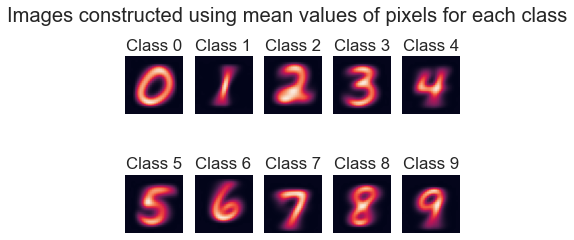

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 4 is 0.09871666666666666
Prior Probability of class 4 is 0.11236666666666667
Prior Probability of class 4 is 0.0993
Prior Probability of class 4 is 0.10218333333333333
Prior Probability of class 4 is 0.09736666666666667
Prior Probability of class 4 is 0.09035
Prior Probability of class 4 is 0.09863333333333334
Prior Probability of class 4 is 0.10441666666666667
Prior Probability of class 4 is 0.09751666666666667
Prior Probability of class 4 is 0.09915


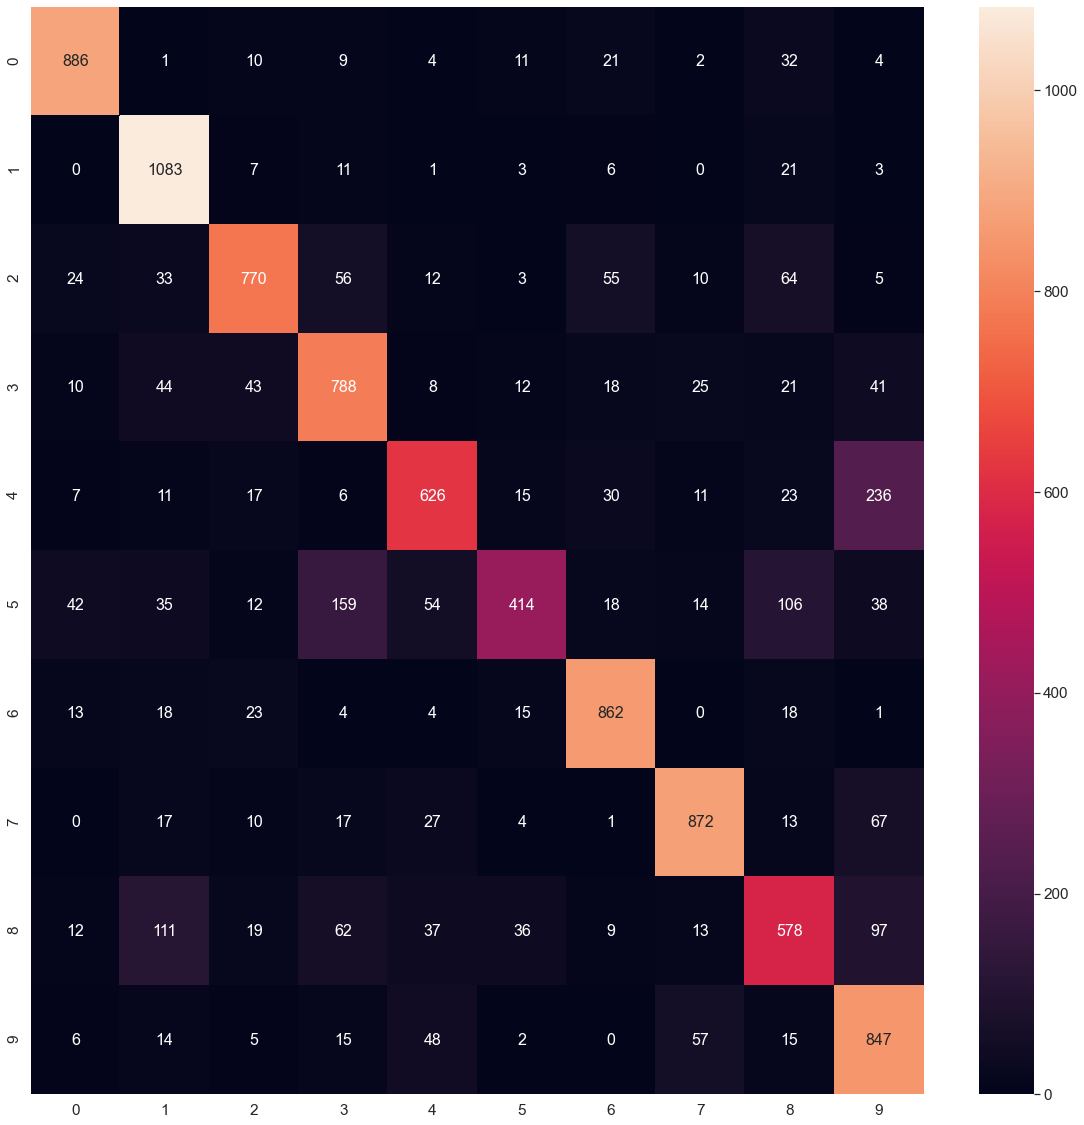

The % of misclassification is 22.74% when the noise added to the lambda is 0.5


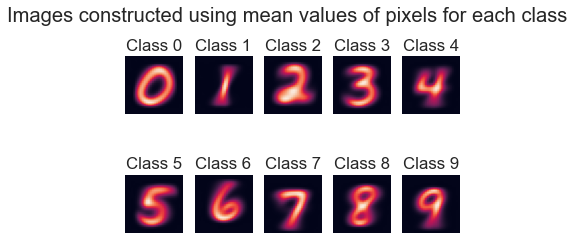

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 5 is 0.09871666666666666
Prior Probability of class 5 is 0.11236666666666667
Prior Probability of class 5 is 0.0993
Prior Probability of class 5 is 0.10218333333333333
Prior Probability of class 5 is 0.09736666666666667
Prior Probability of class 5 is 0.09035
Prior Probability of class 5 is 0.09863333333333334
Prior Probability of class 5 is 0.10441666666666667
Prior Probability of class 5 is 0.09751666666666667
Prior Probability of class 5 is 0.09915


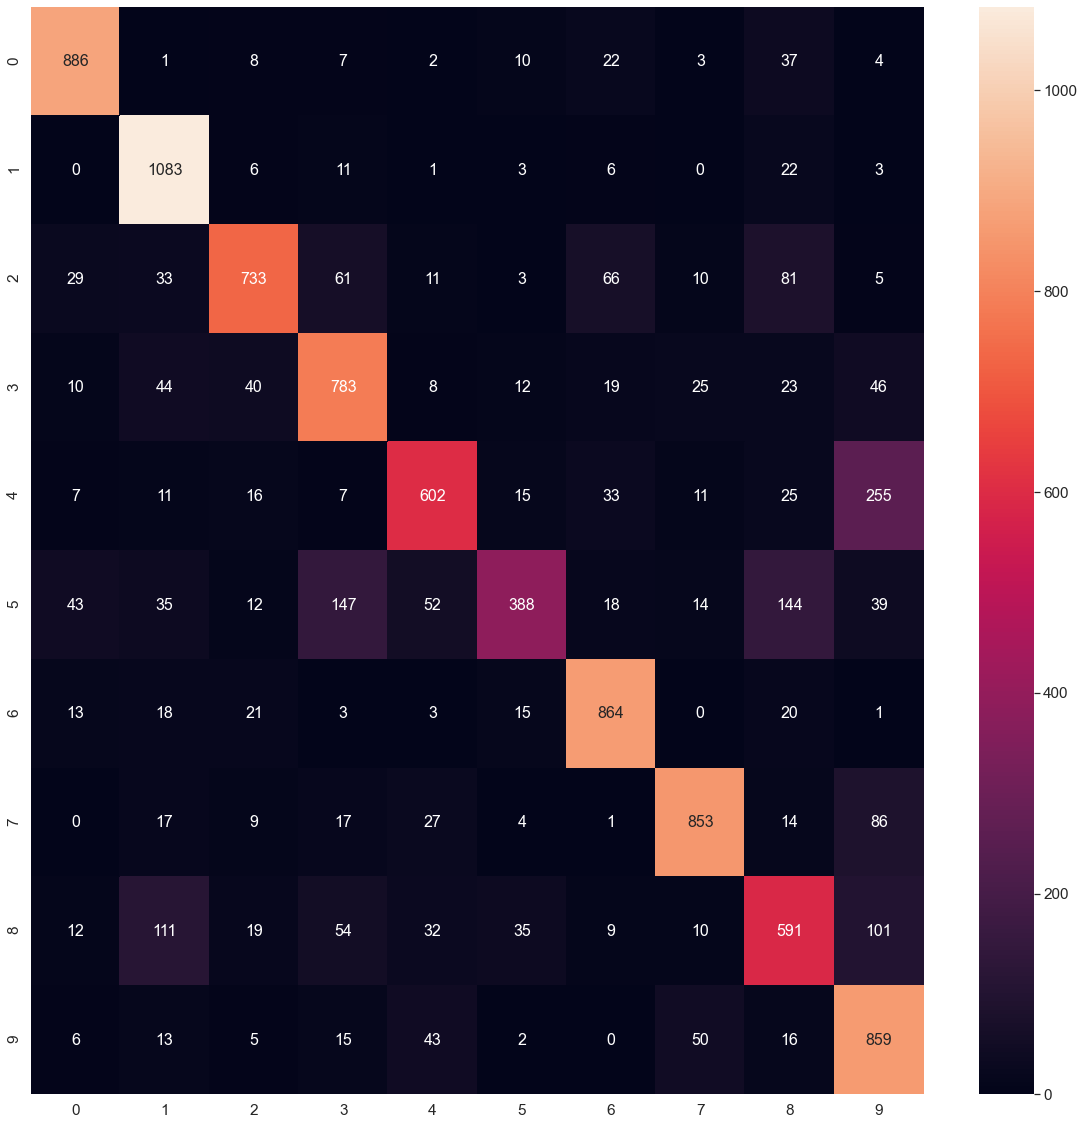

The % of misclassification is 23.580000000000002% when the noise added to the lambda is 0.8


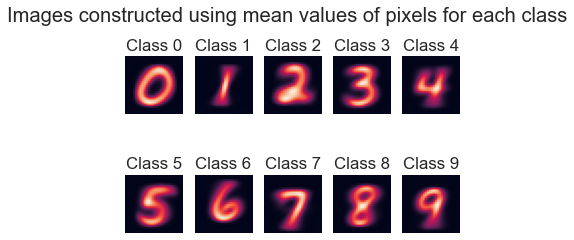

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 6 is 0.09871666666666666
Prior Probability of class 6 is 0.11236666666666667
Prior Probability of class 6 is 0.0993
Prior Probability of class 6 is 0.10218333333333333
Prior Probability of class 6 is 0.09736666666666667
Prior Probability of class 6 is 0.09035
Prior Probability of class 6 is 0.09863333333333334
Prior Probability of class 6 is 0.10441666666666667
Prior Probability of class 6 is 0.09751666666666667
Prior Probability of class 6 is 0.09915


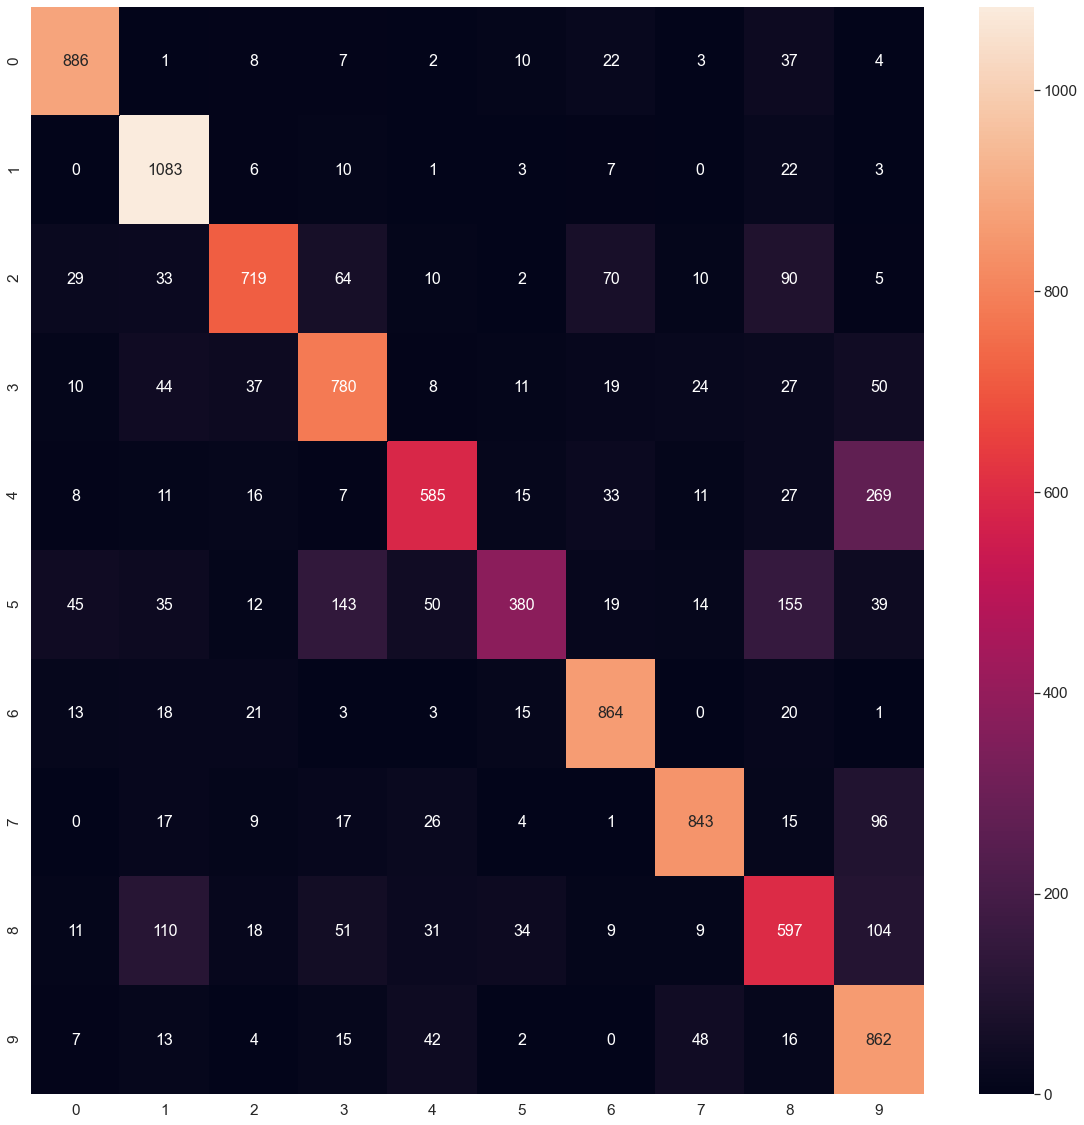

The % of misclassification is 24.01% when the noise added to the lambda is 1
The % of misclassification is less for noise value 0.18 added to the lamda when lambda goes to infinity
The corresponding % misclassification is 21.67


In [879]:
mndata=MNIST(r"Dataset_spr_2")  #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels

train_images, train_labels=mndata.load_training()      #loads training images and their labels
test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
test_images=np.array(test_images)

print(f"Total no. of images uses for training : {str(len(train_images))}")
print(f"No. of pixel values for each image : {str(np.shape(train_images)[1])}")
print(f"No. of classes is : {str(np.max(train_labels)+1)}")

#print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution")
#the below values of lamda are for replacing the lamda value with one particular value in a iteration when it is equal to infinity

lamda_smoothing=[0,0.1,0.18,0.3,0.5,0.8,1]
mis_clf=np.zeros((len(lamda_smoothing),1))
perc_misclf=np.zeros((len(lamda_smoothing),1))

for i in range(len(lamda_smoothing)):
    lamda,prior_prob = mle_estimation_exp(train_images,train_labels,lamda_smoothing[i])
    print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution")
    for j in range(np.max(train_labels)+1):
        print("Prior Probability of class " + str(i) + " is "  + str(prior_prob[j,0]))
    
    conf_matrix,mis_clf[i] = bayes_clasfr(test_images,test_labels,lamda,prior_prob)
    plot_cnf_matrix(conf_matrix)
    perc_misclf[i]= mis_clf[i]/len(test_labels)
    print(f"The % of misclassification is {str(perc_misclf[i,0]*100)}% when the noise added to the lambda is {lamda_smoothing[i]}")


print(f"The % of misclassification is less for noise value {lamda_smoothing[int(np.argmin(perc_misclf))]} added to the lamda when lambda goes to infinity")
print(f"The corresponding % misclassification is {np.min(perc_misclf)*100}")                                                                               
   


## Problem 3: 

## We have considered MNIST Fashion Dataset and used Multivariate Gaussian and Multivariate Exponential Distribution for modeling Class Conditional Densities

Training Data consists of 60,000 small square 28×28 pixel grayscale images of fashion items of 10 types.Testing Data consists of 10,000 small square 28×28 pixel grayscale images of fashion items of 10 types.
The mapping of all 0-9 integers to class labels is listed below.

$0 :$ T-shirt/top $\newline$
$1 :$ Trouser  $\newline$
$2 :$ Pullover  $\newline$
$3 :$ Dress  $\newline$
$4 :$ Coat $\newline$
$5 :$ Sandal $\newline$
$6 :$ Shirt $\newline$
$7 :$ Sneaker $\newline$
$8 :$ Bag $\newline$
$9 :$ Ankle boot $\newline$

#### Trianing and Testing with Class conditional Densities modeled as Multivariate Gaussian Distribution

Total no. of images uses for training : 60000
No. of pixel values for each image : 784
No. of classes is : 10
Classifier : Bayes Classifier and Class Conditional densities for training Data : Mulitvariate Gaussian Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


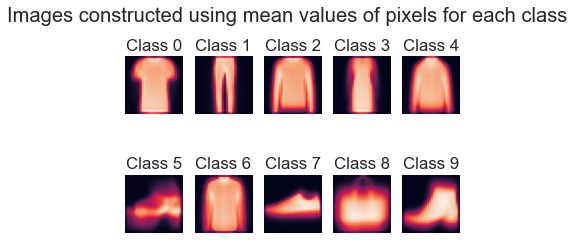

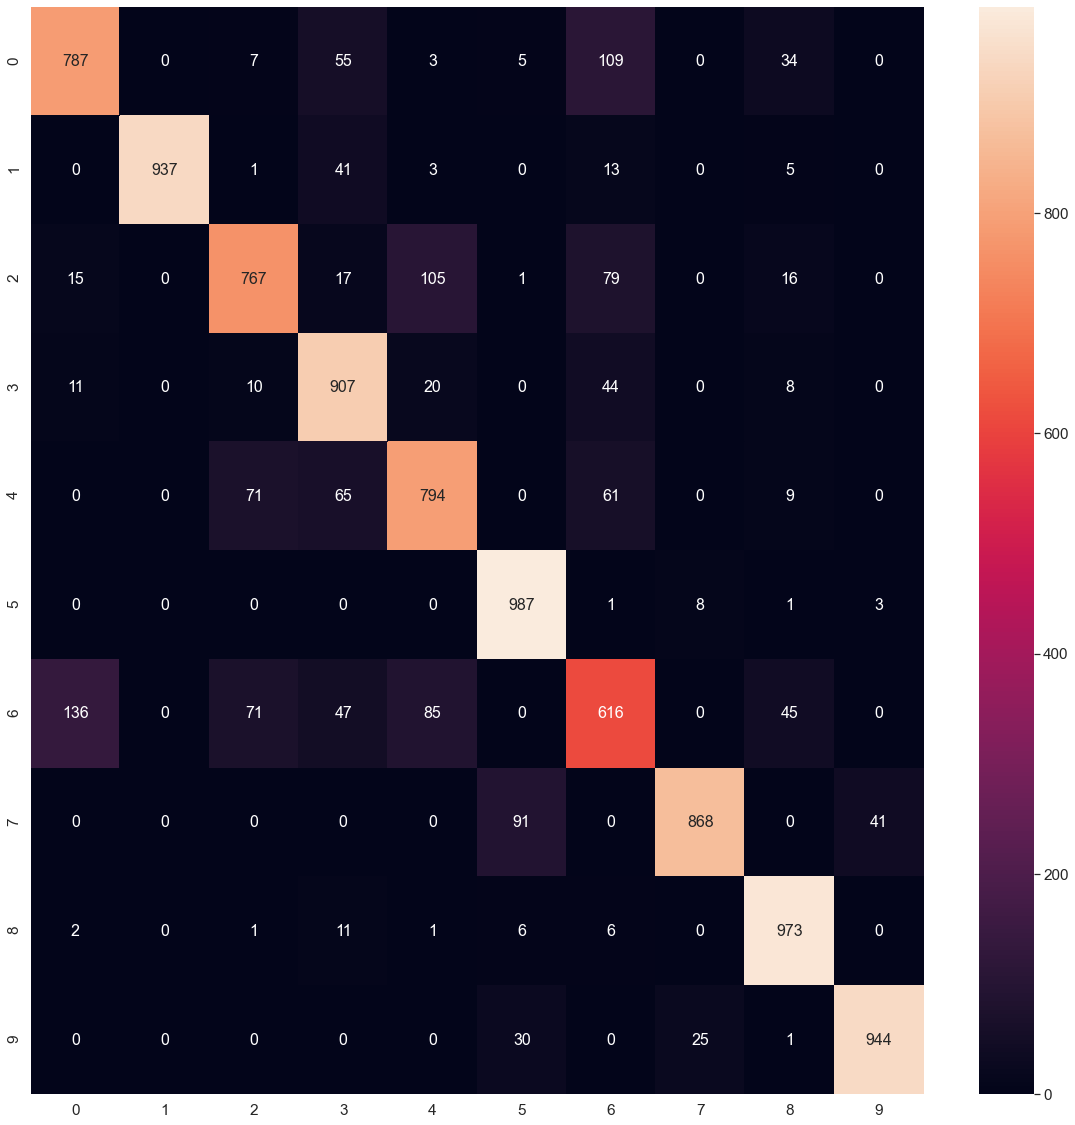

The % of misclassification is 14.2% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution


In [870]:
mndata=MNIST(r"MNIST_fashion") #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels

train_images, train_labels=mndata.load_training()      #loads training images and their labels
#print(np.shape(train_images[1]))         #(60,0000,784) there are 60,000 images with each of size 28x28  
#print(np.shape(train_labels))         #(60,000,) labels
test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
test_images=np.array(test_images)
#print(np.shape(test_images))

mu,covariance,prior_prob = mle_estimation_gaussian(train_images,train_labels)

print(f"Total no. of images uses for training : {str(len(train_images))}")
print(f"No. of pixel values for each image : {str(np.shape(train_images)[1])}")
print(f"No. of classes is : {str(np.max(train_labels)+1)}")
print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data : Mulitvariate Gaussian Distribution")
for i in range(np.max(train_labels)+1):
    print("Prior Probability of class " + str(i) + " is "  + str(prior_prob[i,0]))

conf_matrix,mis_clf = bayes_clasfr_gaussian(test_images,test_labels,mu,covariance,prior_prob)

plot_cnf_matrix(conf_matrix)

perc_misclf= mis_clf/len(test_labels)

print(f"The % of misclassification is {str(perc_misclf*100)}% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution")



#### Trianing and Testing with Class conditional Densities modeled as Multivariate Exponentail Distribution

Total no. of images uses for training : 60000
No. of pixel values for each image : 784
No. of classes is : 10


<ipython-input-864-c7f80f3173d1>:10: RuntimeWarning: divide by zero encountered in true_divide
  lamda= np.array([1/((np.mean(classes[i],axis=0))) for i in range(np.max(train_labels)+1)])  #generate the MLE estimate of parameter lamda vector for each class
<ipython-input-864-c7f80f3173d1>:24: RuntimeWarning: divide by zero encountered in true_divide
  train_imag1=np.array(1/(train_imag1))


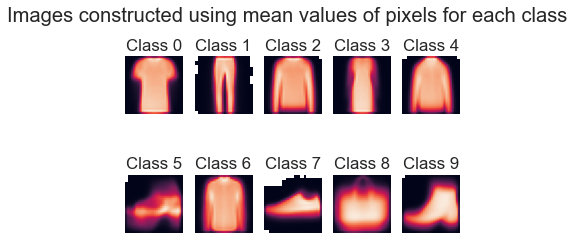

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


<ipython-input-865-a702fd3e510d>:12: RuntimeWarning: divide by zero encountered in log
  pst_prob[j]= np.sum(np.log(lamda_temp))+np.sum(-lamda_temp*dmy)+np.log(prior_prob[j])#np.sum(np.log(lamda_temp))-np.sum(lamda*dmy) + np.log(prior_prob[j])   #find the PDF of the feature vector that follows the given distribution


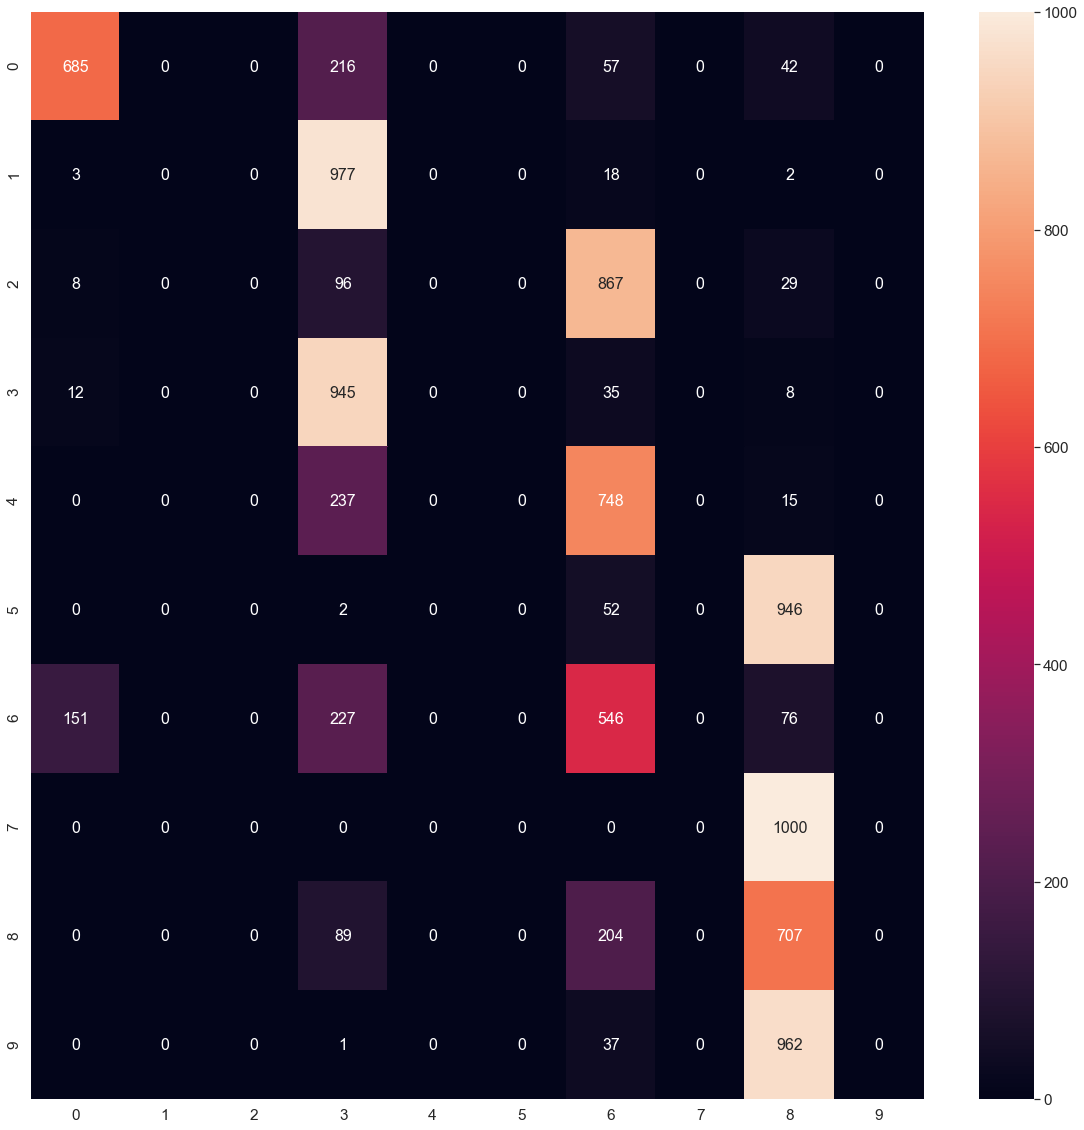

The % of misclassification is [71.17]% when the noise added to the lambda is 0


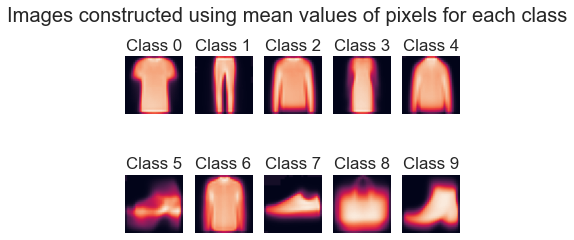

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


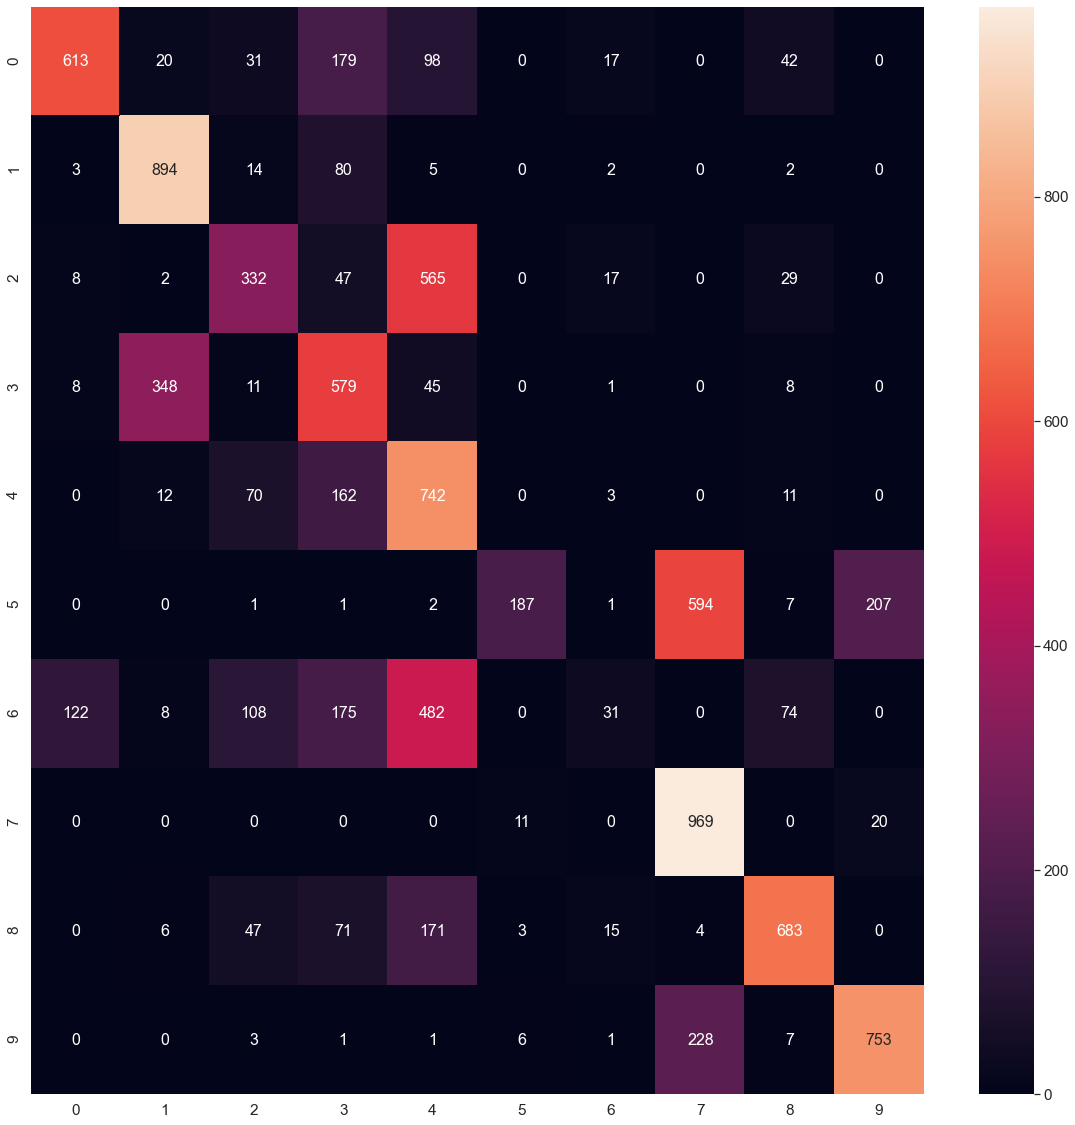

The % of misclassification is [42.17]% when the noise added to the lambda is 0.1


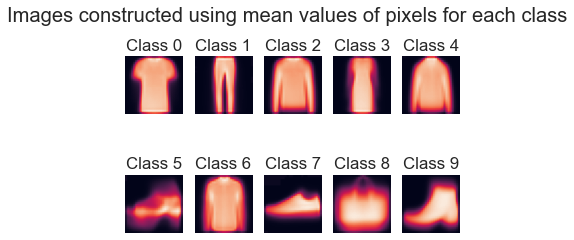

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


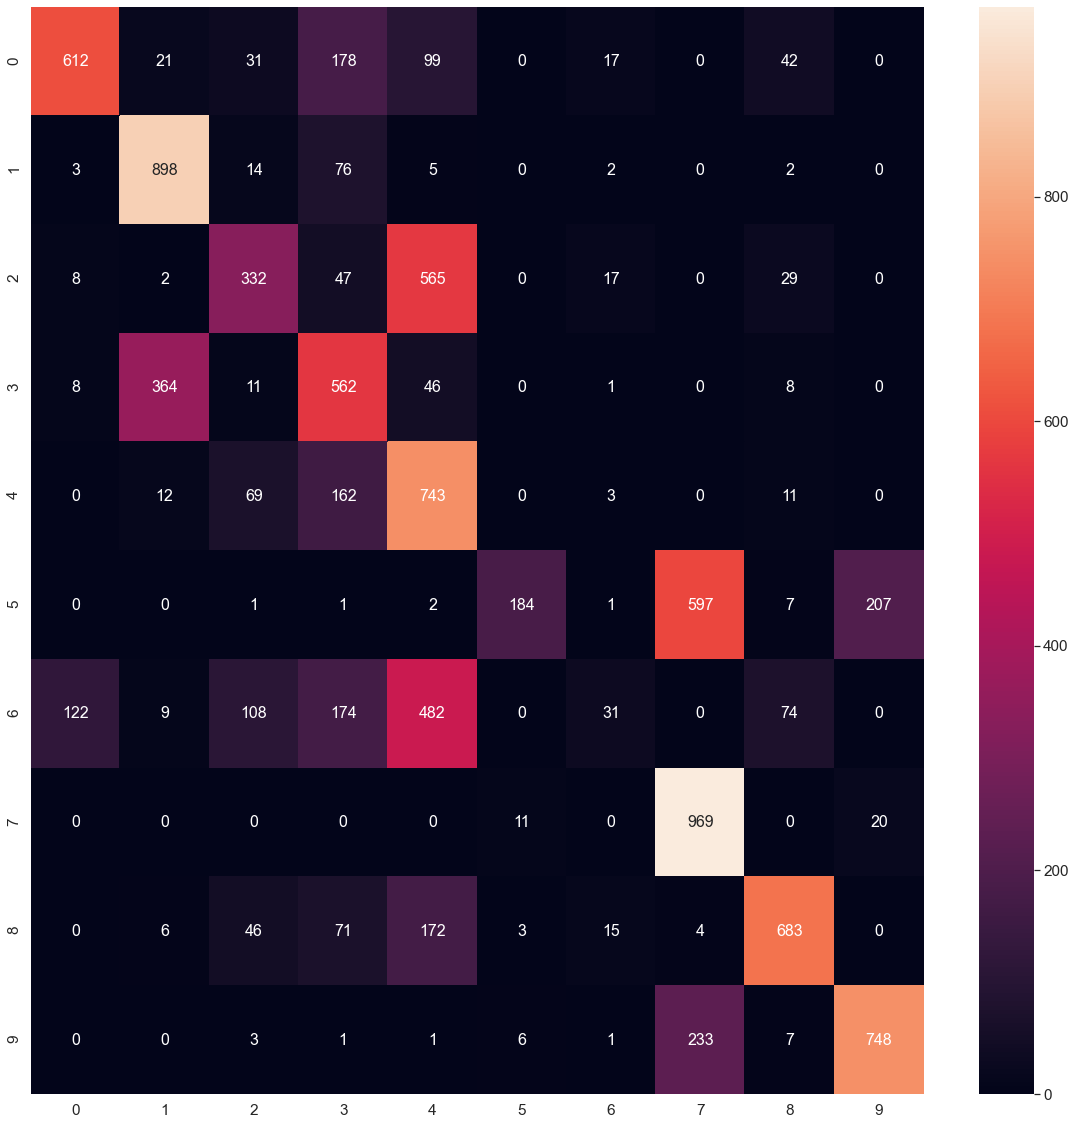

The % of misclassification is [42.38]% when the noise added to the lambda is 0.18


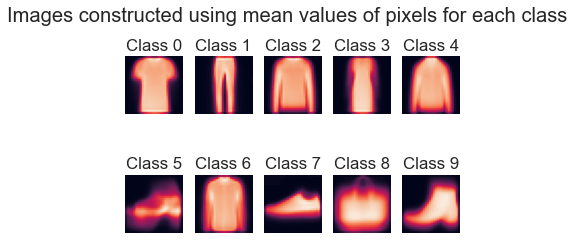

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


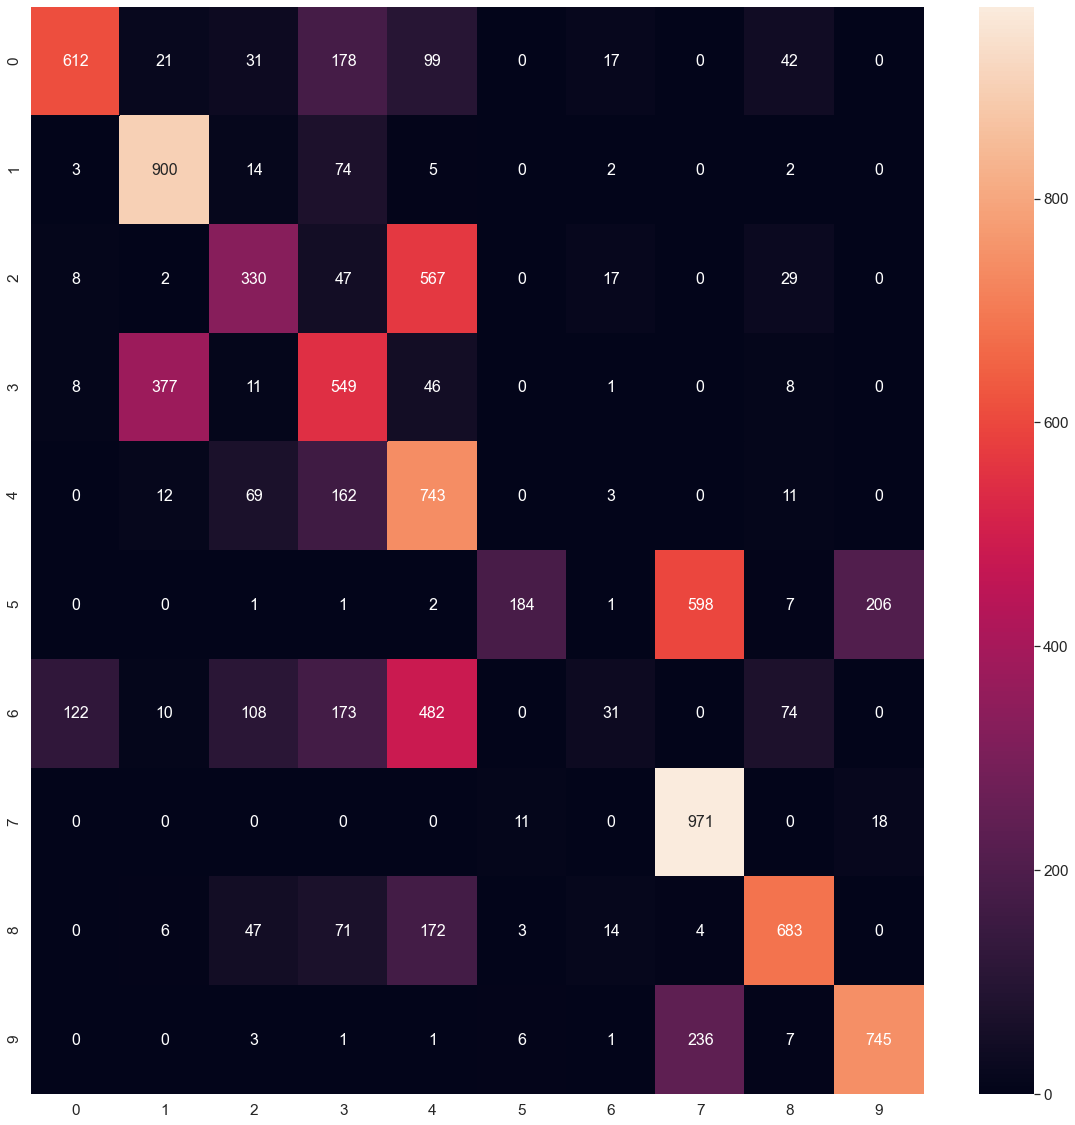

The % of misclassification is [42.52]% when the noise added to the lambda is 0.3


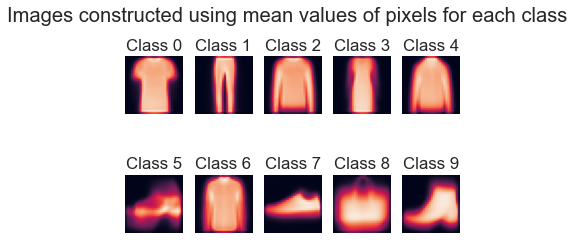

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


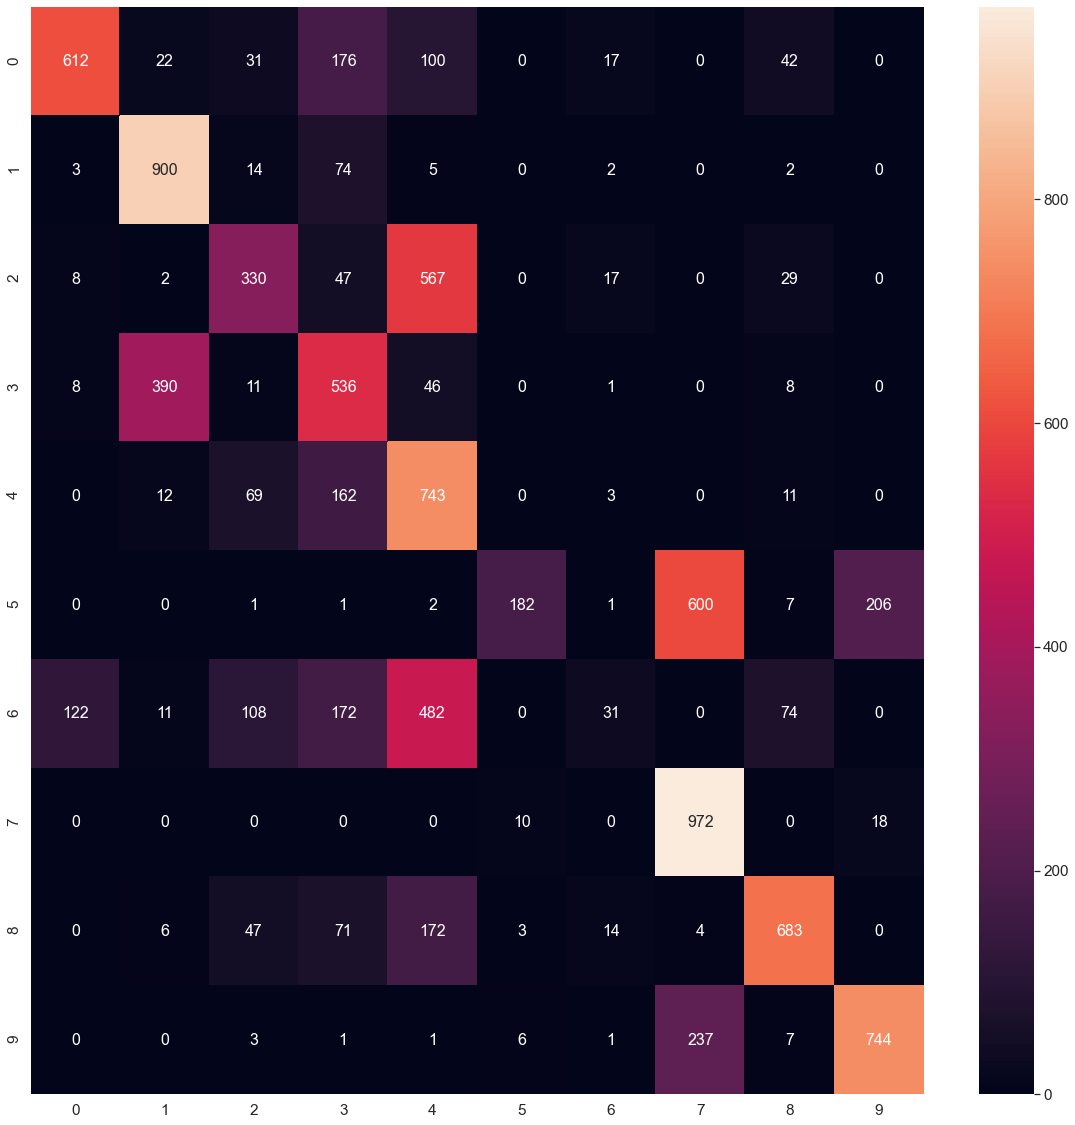

The % of misclassification is [42.67]% when the noise added to the lambda is 0.5


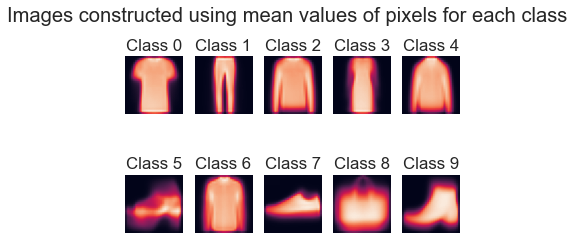

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


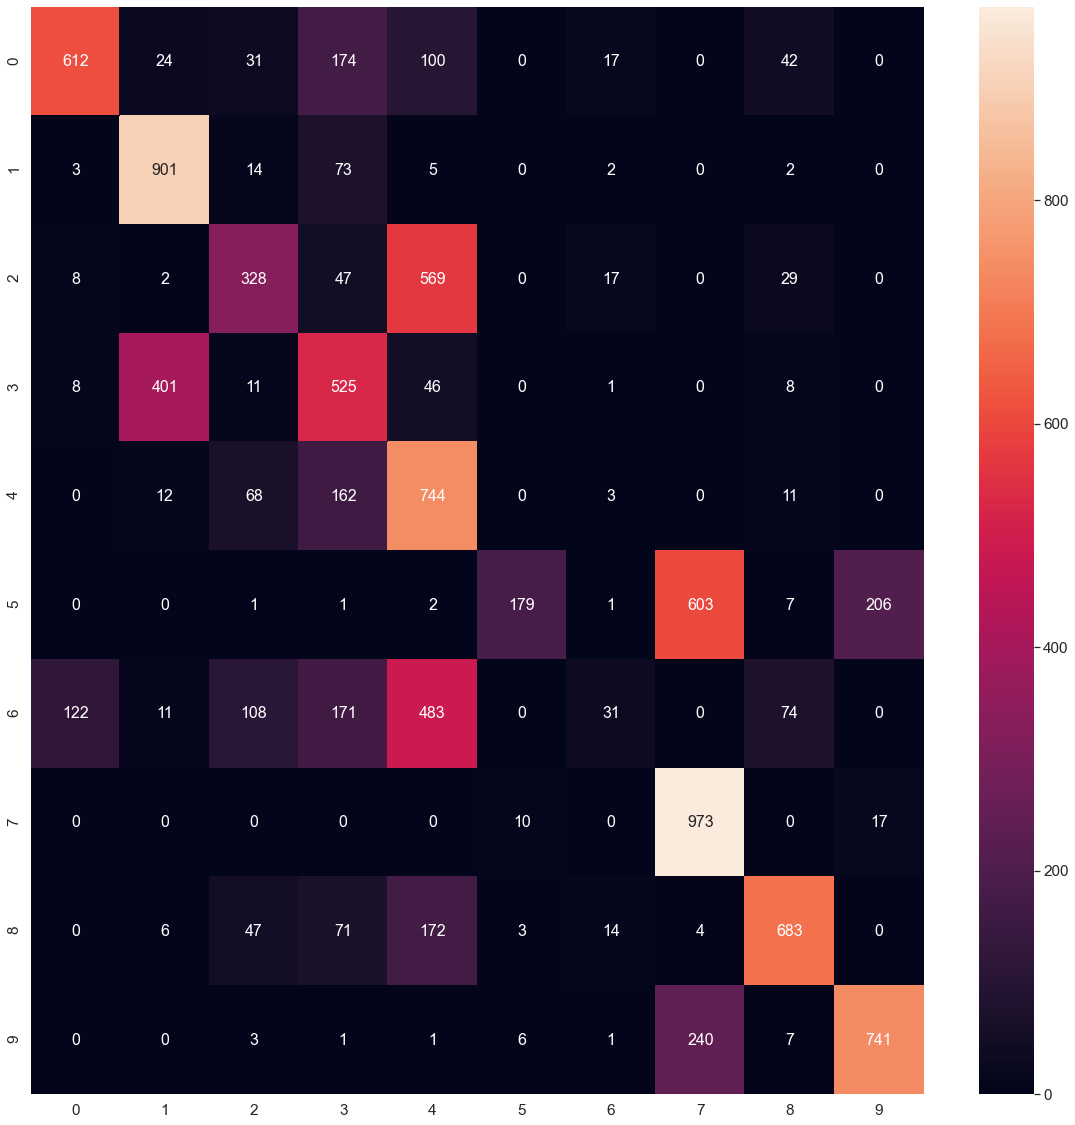

The % of misclassification is [42.83]% when the noise added to the lambda is 0.8


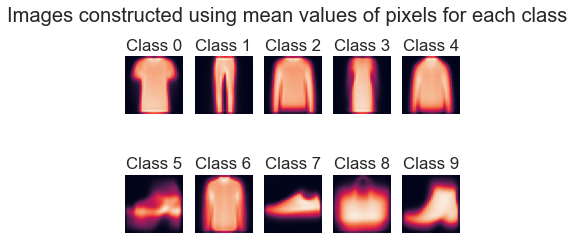

Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution
Prior Probability of class 0 is 0.1
Prior Probability of class 1 is 0.1
Prior Probability of class 2 is 0.1
Prior Probability of class 3 is 0.1
Prior Probability of class 4 is 0.1
Prior Probability of class 5 is 0.1
Prior Probability of class 6 is 0.1
Prior Probability of class 7 is 0.1
Prior Probability of class 8 is 0.1
Prior Probability of class 9 is 0.1


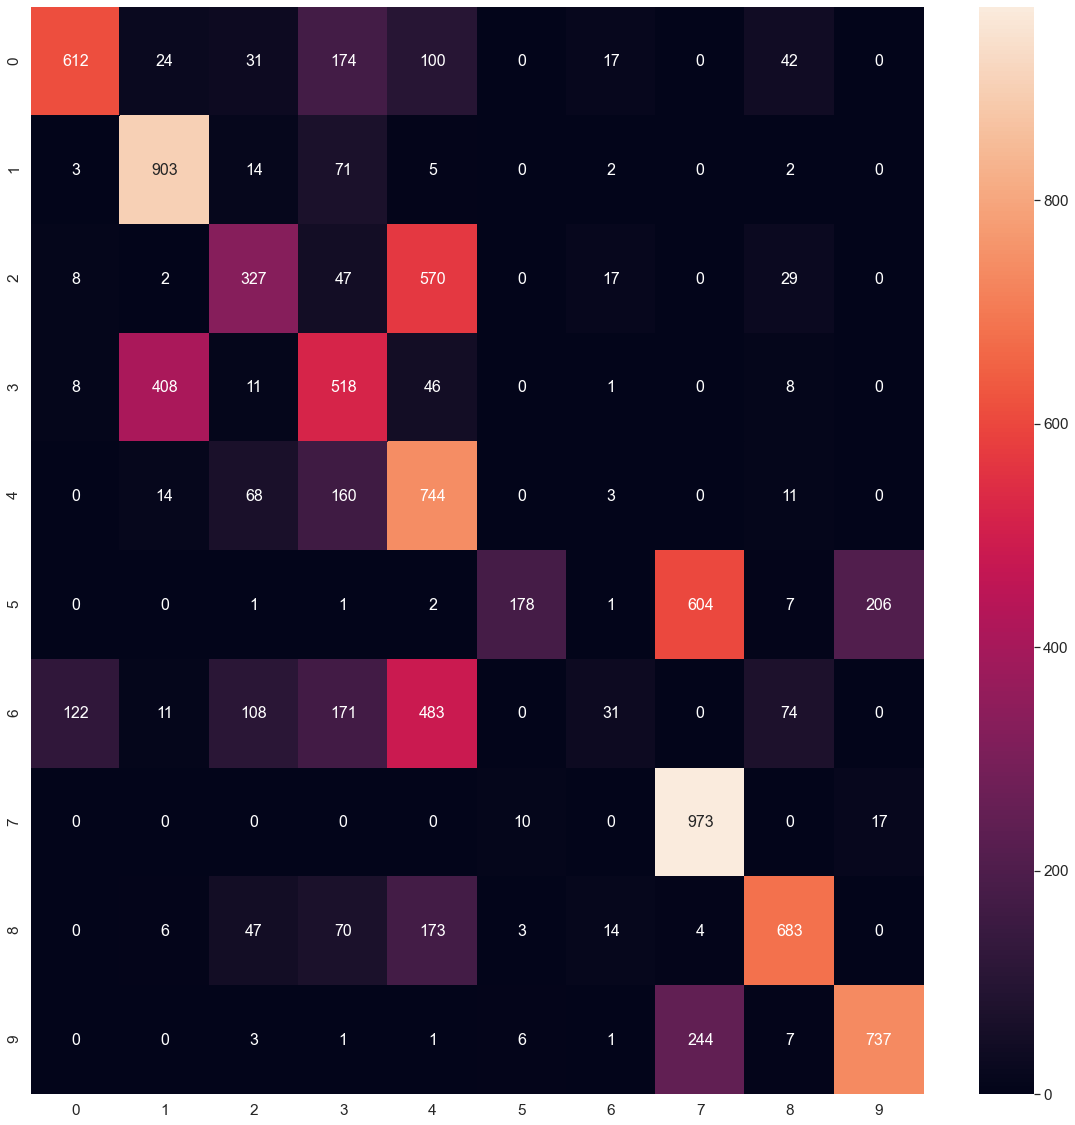

The % of misclassification is [42.94]% when the noise added to the lambda is 1
The % of misclassification is less for noise value 0.1 added to the lamda when lambda goes to infinity
The corresponding % misclassification is 0.4217


In [878]:
mndata=MNIST(r"MNIST_fashion")  #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels

train_images, train_labels=mndata.load_training()      #loads training images and their labels
test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
test_images=np.array(test_images)

#the below values of lamda are for replacing the lamda value with one particular value in a iteration when it is equal to infinity
lamda_smoothing=[0,0.1,0.18,0.3,0.5,0.8,1]
mis_clf=np.zeros((len(lamda_smoothing),1))
perc_misclf=np.zeros((len(lamda_smoothing),1))

print(f"Total no. of images uses for training : {str(len(train_images))}")
print(f"No. of pixel values for each image : {str(np.shape(train_images)[1])}")
print(f"No. of classes is : {str(np.max(train_labels)+1)}")
      
#print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution")
for i in range(len(lamda_smoothing)):
    lamda,prior_prob = mle_estimation_exp(train_images,train_labels,lamda_smoothing[i])
    print(f"Classifier : Bayes Classifier and Class Conditional densities for training Data is Mulitvariate Exponential Distribution")
    for j in range(np.max(train_labels)+1):
        print("Prior Probability of class " + str(j) + " is "  + str(prior_prob[j,0]))
    
    conf_matrix,mis_clf[i] = bayes_clasfr(test_images,test_labels,lamda,prior_prob)
    plot_cnf_matrix(conf_matrix)
    perc_misclf[i]= mis_clf[i]/len(test_labels)
    print(f"The % of misclassification is {perc_misclf[i]*100}% when the noise added to the lambda is {lamda_smoothing[i]}")

print(f"The % of misclassification is less for noise value {lamda_smoothing[int(np.argmin(perc_misclf))]} added to the lamda when lambda goes to infinity")
print(f"The corresponding % misclassification is {np.min(perc_misclf)*100}")                                                                            
    


#### We combine the classes 0, 2, 4 and 6

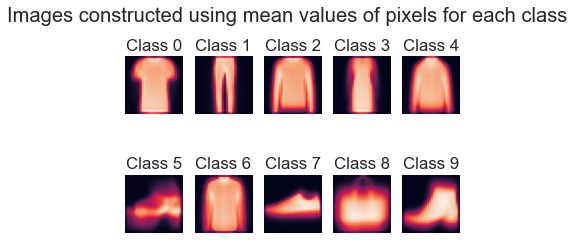

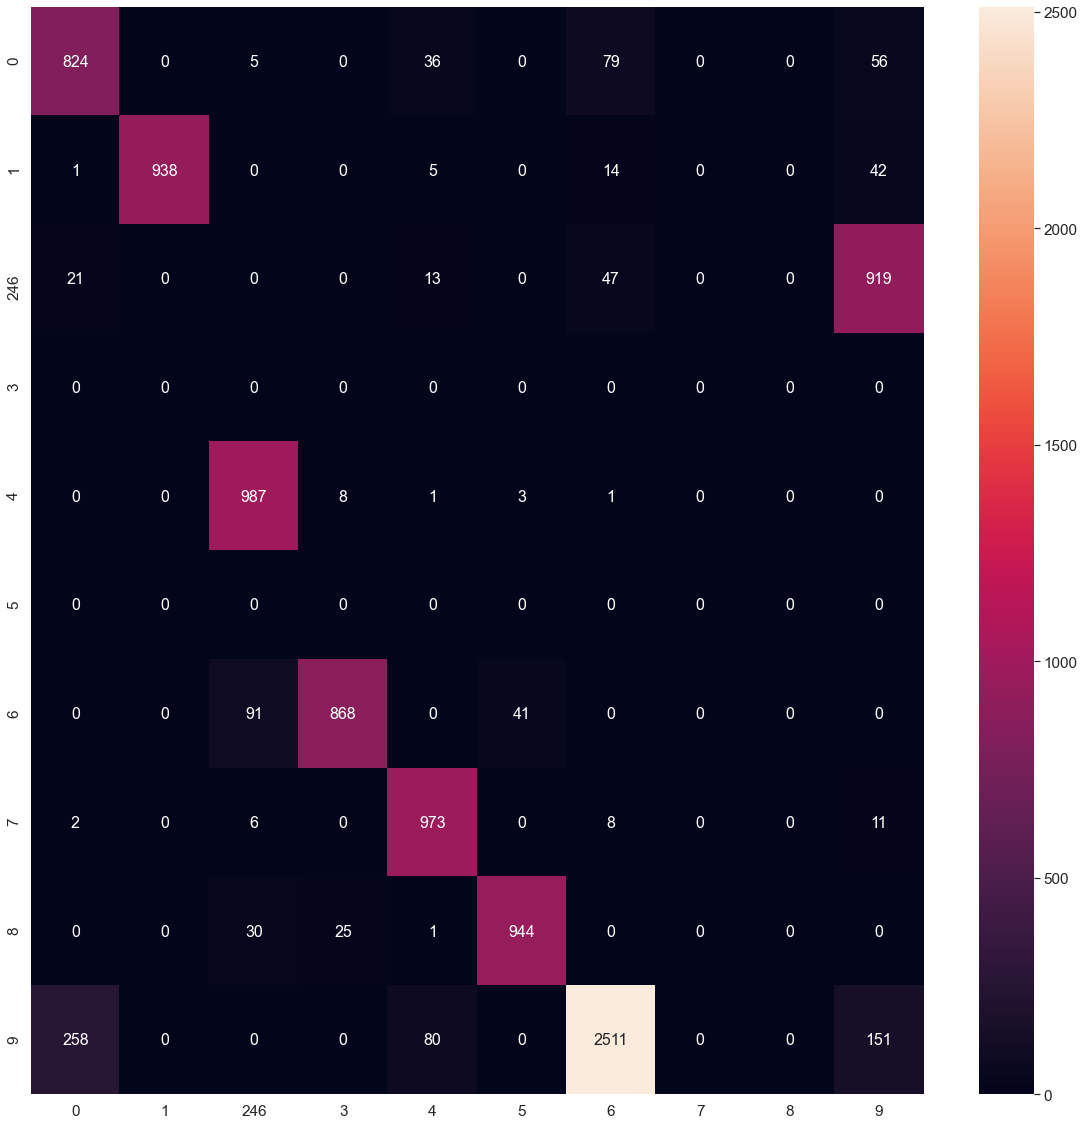

The % of misclassification is 80.86% for MLE estimation assuming the data is sampled from Multivariate Gaussian Distribution with classes 1,3,8 combined


In [896]:
mndata=MNIST(r"MNIST_fashion")  #Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels 

combined_class=[2,4,6]
choose_dataset(mndata,combined_class)

##### Observations for Problem 1 and 3:

* Modeling the class conditional densities as Multivariate Gaussian distribution results in high accuracy compared to the Multivariate Exponential model.
* For MNIST dataset with multivariate gaussian model class 1 and 3 are misclassified as 8 many times. Hence combining these 3 as a single class reduced our misclassification. Hence increasing the accuracy of the model.
* For MNIST Fashion dataset with multivariate exponential model, class 6 is misclassified as 0 many times. Hence combining these 2 would reduce the misclassification thereby increasing the accuracy.
* We have added a noise of 0.35 to the diagonal elements of covariance matrix. Adding a value below this resulted in determinant of covariance matrices of some classes to be zero. When inbuit function multivariate_normal.logpdf(x,mean,covariance) is used to estimate the pdf at x, we were able to get an accuaracy of 87% with noise added to diagonal elements being only 0.01.
* When Multivariate Exponential Model is used, when lambda parameter goes to infinity it is replaced by different values between 0 to 1 (noise addition). We got best accuracy for adding noise as 0.18 when it is infinity. But always the accuracy of multivariate exponential model is less than the multivariate gaussian distribution model. We think this is because both MNIST dataset and MNIST fashion dataset are obtained from Multivariate Gaussian Distribution